# |In this notebook we apply our SEIR model to the h1n1 epidemic data

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from lmfit import Parameters

In [106]:
sns.set()
%matplotlib inline

In [107]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
%autoreload 2

In [165]:
from sir_models.seir import SEIR, CurveFitter, DayAheadFitter
from sir_models.utils import eval_one_day_ahead

# Load data

In [205]:
df = pd.read_csv('data/h1n1/data.csv')

In [206]:
df.columns = ['date', 'country', 'total_infected', 'total_dead', 'link']
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [207]:
df.head()

,date,country,total_infected,total_dead,link
0,2009-04-24,Mexico,18,0,https://www.who.int/csr/don/2009_04_24/en/
1,2009-04-24,United States of America,7,0,https://www.who.int/csr/don/2009_04_24/en/
2,2009-04-26,Mexico,18,0,https://www.who.int/csr/don/2009_04_24/en/
3,2009-04-26,United States of America,20,0,https://www.who.int/csr/don/2009_04_24/en/
4,2009-04-27,Canada,6,0,https://www.who.int/csr/don/2009_04_24/en/


In [208]:
df.groupby('country').sum().sort_values(by='total_infected')

,total_infected,total_dead
country,,
Cook Island,1,0
Croatia,1,0
"Saint Martin, FOC",1,0
"British Virgin Islands, UKOT",1,0
Monaco,1,0
...,...,...
United Kingdom,44768,15
Chile,53976,76
Canada,88970,208


In [209]:
df = df[df.country=='United States of America']
df = df.reset_index(drop=True)
df.index = df.date
df = df.drop(columns=['date', 'link', 'country'])

In [210]:
df.head()

,total_infected,total_dead
date,,
2009-04-24,7,0
2009-04-26,20,0
2009-04-27,40,0
2009-04-28,64,0
2009-04-29,91,1


In [211]:
ix = pd.date_range(start=df.iloc[0].name, end=df.iloc[-1].name, freq='D')
df = df.reindex(ix)
df = df.interpolate().round()
df = df.rolling(3).mean()
df['date'] = ix
df = df.dropna()
df.head()

,total_infected,total_dead,date
2009-04-26,13.666667,0.000000,2009-04-26
2009-04-27,24.666667,0.000000,2009-04-27
2009-04-28,41.333333,0.000000,2009-04-28
2009-04-29,65.000000,0.333333,2009-04-29
2009-04-30,88.000000,0.666667,2009-04-30


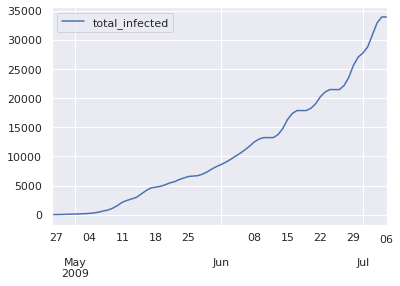

In [212]:
plt.figure()
df.total_infected.plot(label='total_infected')
plt.legend()
plt.show()

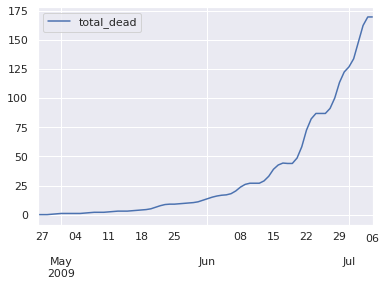

In [213]:
plt.figure()
df.total_dead.plot(label='total_dead')
plt.legend()
plt.show()

# Set fixed params

In [214]:
population = 306.8 * 10e6

In [215]:
class SEIRH1N1(SEIR):
    def get_fit_params(self, data):
        params = Parameters()
        # Non-variable
        params.add("base_population", value=population, vary=False)
        params.add("pre_existing_immunity", value=0, vary=False)
        params.add("sus_population", expr='base_population - base_population * pre_existing_immunity', vary=False)
        params.add("r0", value=1.5, min=0.5, max=4, vary=True)

        params.add("delta", value=1/2, min=1e-10, max=1, vary=False) # E -> I rate
        params.add("gamma", value=1/6, min=1e-10, max=1, vary=False) # I -> R rate
        params.add("rho", value=1/6, min=1e-10, max=1, vary=False) # I -> D rate

        # Variable
        params.add("alpha", value=0.0002, min=0.0001, max=0.05, vary=True) # Probability to die if infected
        
        params.add(f"t0_q", value=0, min=0, max=0.99, brute_step=0.1, vary=False)
        piece_size = 60
        for t in range(piece_size, len(data), piece_size):
          params.add(f"t{t}_q", value=0, min=0, max=0.99, brute_step=0.1, vary=False)

        return params

In [216]:
df.iloc[0]

total_infected                13.6667
total_dead                          0
date              2009-04-26 00:00:00
Name: 2009-04-26 00:00:00, dtype: object

# Train model with CurveFitter

In [217]:
model = SEIRH1N1(verbose=False)
fitter = CurveFitter(use_recovered=False)
fitter.fit(model, df)
result = fitter.result

In [218]:
result

In [219]:
train_initial_conditions = fitter.get_initial_conditions(model, df)
train_t = np.arange(len(df))

(S, E, I, R, D), history = model.predict(train_t, train_initial_conditions)

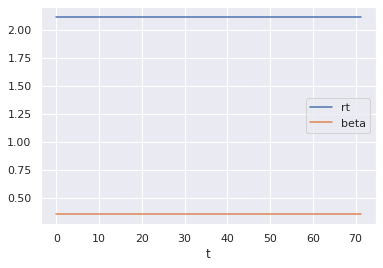

In [220]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

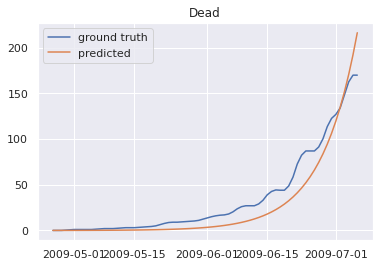

In [221]:
plt.figure()
plt.plot(df.index, df['total_dead'], label='ground truth')
plt.plot(df.index, D, label='predicted')
plt.legend()
plt.title('Dead')
plt.show()

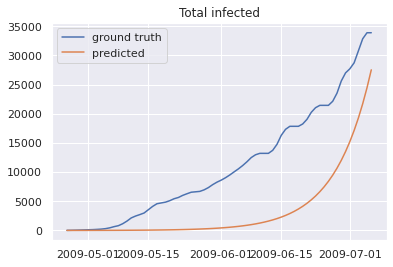

In [222]:
plt.figure()
plt.plot(df.index, df['total_infected'], label='ground truth')
plt.plot(df.index, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()

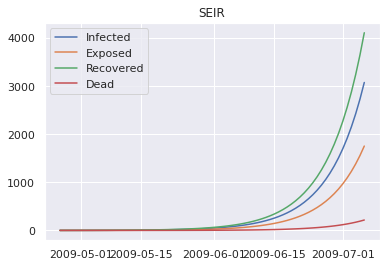

In [223]:
plt.figure()
plt.plot(df.index, I, label='Infected')
plt.plot(df.index, E, label='Exposed')
plt.plot(df.index, R, label='Recovered')
plt.plot(df.index, D, label='Dead')
plt.legend()
plt.title('SEIR')
plt.show()

In [229]:
eval_one_day_ahead(df, SEIRH1N1, CurveFitter, eval_period_start=df.iloc[10].date, n_eval_points=10)


Baseline D mae 0.0
Model D mae 13.025


(0.0, 13.025229006186725)

# Train model using DayAheadFitter

In [233]:
model = SEIRH1N1(verbose=True)
fitter = DayAheadFitter(use_recovered=False, n_eval_points=False)
fitter.fit(model, df)
result = fitter.result


Mae: 1.838962689336839



Mae: 1.838962689336839



Mae: 1.838962689336839



Mae: 1.8389652710328324



Mae: 1.8389655853706721



Mae: 1.8654234632278288



Mae: 1.857578614571879



Mae: 1.9940575444229445



Mae: 1.893005070314263



Mae: 1.8058253296024307



Mae: 1.812782919490409



Mae: 1.8127854956070635



Mae: 1.8127858092958147



Mae: 1.7739680858289293



Mae: 1.8781975012944665



Mae: 1.8107000287271298



Mae: 1.810702604378922



Mae: 1.810702918011946



Mae: 1.814257620129252



Mae: 1.8142601963950276



Mae: 1.8142605103319056



Mae: 1.7388821152375886



Mae: 1.738884233054723



Mae: 1.7388844480671695



Mae: 1.809686426637129



Mae: 1.7375510105601037



Mae: 1.737553128085739



Mae: 1.737553343066145



Mae: 1.7349236301055035



Mae: 1.734925747054095



Mae: 1.734925961993215



Mae: 1.87568783940371



Mae: 1.8781060842487833



Mae: 1.7348711036557993



Mae: 1.7348732205930093



Mae: 1.734873435523318



Mae: 1.7347661064021778



Mae: 1.7347682233132378



Mae: 1.734768438245346



Mae: 1.8781885640926024



Mae: 1.7347661064021778


In [234]:
train_initial_conditions = fitter.get_initial_conditions(model, df)
train_t = np.arange(len(df))

(S, E, I, R, D), history = model.predict(train_t, train_initial_conditions)

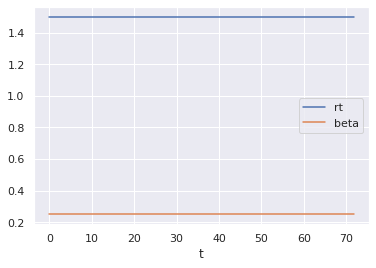

In [235]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

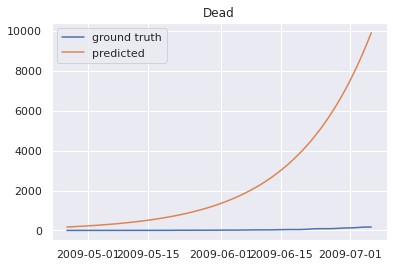

In [236]:
plt.figure()
plt.plot(df.index, df['total_dead'], label='ground truth')
plt.plot(df.index, D, label='predicted')
plt.legend()
plt.title('Dead')
plt.show()

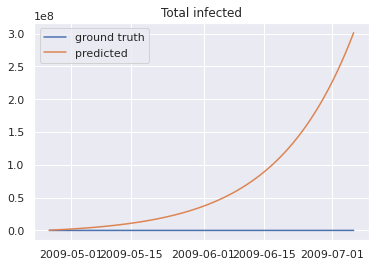

In [237]:
plt.figure()
plt.plot(df.index, df['total_infected'], label='ground truth')
plt.plot(df.index, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()

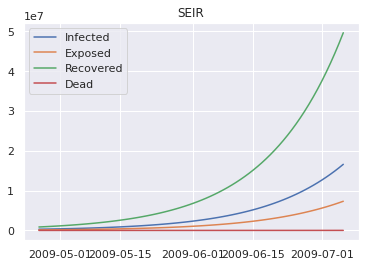

In [238]:
plt.figure()
plt.plot(df.index, I, label='Infected')
plt.plot(df.index, E, label='Exposed')
plt.plot(df.index, R, label='Recovered')
plt.plot(df.index, D, label='Dead')
plt.legend()
plt.title('SEIR')
plt.show()

In [239]:
eval_one_day_ahead(df, SEIRH1N1, DayAheadFitter, eval_period_start=df.iloc[10].date, n_eval_points=10)


Baseline D mae 0.0
Model D mae 864.687


(0.0, 864.6872014246698)